# Stock Market Analysis and Prediction using LSTM :

In [1]:
import pandas as pd 
import numpy as np  
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import torch
import torch.nn as nn

import warnings 
warnings.filterwarnings('ignore')

## Explore & Prepare :

In [2]:
data = pd.read_csv('stock-market-data.csv')
data .head()

,Date,Open,High,Low,Close,Volume
0,7/21/2014,94.99,95.00,93.72,93.94,38887700
1,7/18/2014,93.62,94.74,93.02,94.43,49898600
2,7/17/2014,95.03,95.28,92.57,93.09,57152000
3,7/16/2014,96.97,97.10,94.74,94.78,53396300
4,7/15/2014,96.80,96.85,95.03,95.32,45477900


In [3]:
data.shape

(3659, 6)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3659 entries, 0 to 3658
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3659 non-null   object 
 1   Open    3659 non-null   float64
 2   High    3659 non-null   float64
 3   Low     3659 non-null   float64
 4   Close   3659 non-null   float64
 5   Volume  3659 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 171.6+ KB


In [5]:
data.isna().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [6]:
data = data [['Date', 'Close']] 

data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date')

data.set_index('Date', drop=True, inplace=True) 
data.head()

,Close
Date,
2000-01-03,111.94
2000-01-04,102.50
2000-01-05,104.00
2000-01-06,95.00
2000-01-07,99.50


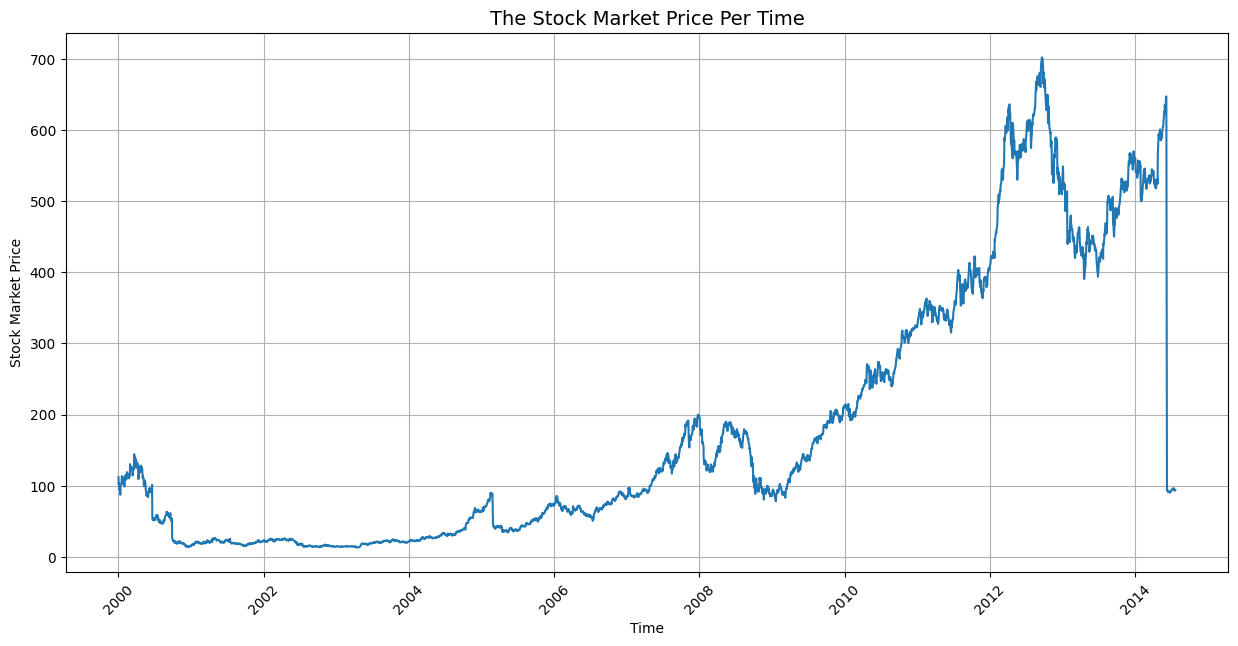

In [7]:
plt.figure(figsize=(15, 7))
plt.plot(data.index, data['Close'])
plt.title('The Stock Market Price Per Time', fontsize=14)
plt.xlabel('Time')
plt.ylabel('Stock Market Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [8]:
# Normalization 
scaler = MinMaxScaler(feature_range=(0, 1))
data['Close_Normalized'] = scaler.fit_transform(data[['Close']])
# data[data.columns] = scaler.fit_transform(data)

data.head()

,Close,Close_Normalized
Date,,
2000-01-03,111.94,0.143429
2000-01-04,102.50,0.129728
2000-01-05,104.00,0.131905
2000-01-06,95.00,0.118842
2000-01-07,99.50,0.125374


In [9]:
# Prepare data for LSTM model
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 15
X, y = create_sequences(data['Close_Normalized'].values, SEQ_LENGTH)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Reshape X_train and X_test to add the input_size dimension
X_train = X_train.unsqueeze(-1)
X_test = X_test.unsqueeze(-1)

print(len(X_train), len(X_test))

2915 729


In [10]:
len(X_train[0])

15

## Train and evaluate :

In [11]:
# Define LSTM
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=48, num_layers=2, dropout=0.2, output_size=1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden and cell states with the correct batch size
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # LSTM layer
        out, _ = self.lstm(x, (h0, c0))  
        
        # Fully connected layer for prediction
        out = self.fc(out[:, -1, :])  
        return out

In [12]:
# Instantiate the model, define loss function and optimizer
model = LSTM(input_size=1, hidden_size=48, num_layers=2, output_size=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
model.train()

for epoch in range(num_epochs):
    outputs = model(X_train)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train.unsqueeze(1))  # Unsqueeze to match output shape
    loss.backward()
    
    # Optimize
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.0666
Epoch [20/100], Loss: 0.0538
Epoch [30/100], Loss: 0.0270
Epoch [40/100], Loss: 0.0065
Epoch [50/100], Loss: 0.0030
Epoch [60/100], Loss: 0.0034
Epoch [70/100], Loss: 0.0023
Epoch [80/100], Loss: 0.0018
Epoch [90/100], Loss: 0.0015
Epoch [100/100], Loss: 0.0015


Mean Squared Error (MSE): 195.6144
R-squared (R2): 0.9941


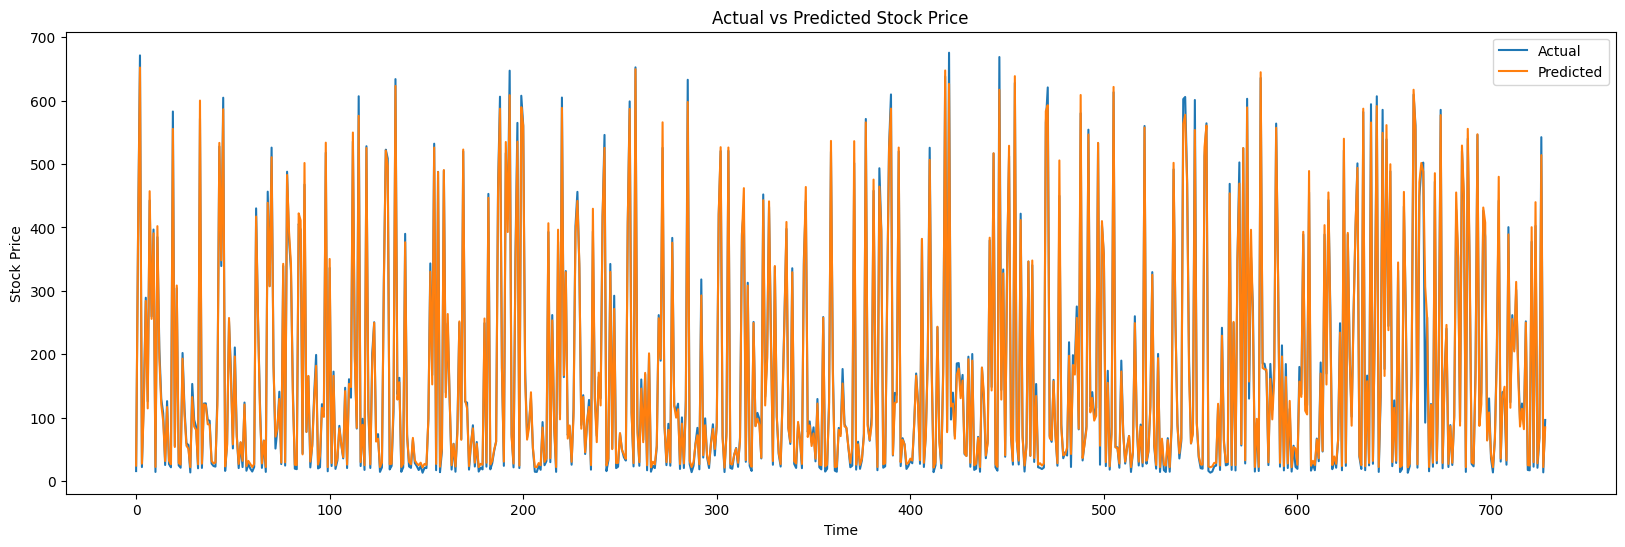

In [13]:
# Evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test)

# Rescale predictions back to original scale
y_test_rescaled = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))
y_pred_rescaled = scaler.inverse_transform(y_pred.numpy())

# Calculate evaluation metrics
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'R-squared (R2): {r2:.4f}')

# Plot actual vs predicted values
plt.figure(figsize=(20, 6))
plt.plot(y_test_rescaled, label='Actual')
plt.plot(y_pred_rescaled, label='Predicted')
plt.title('Actual vs Predicted Stock Price')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()